# 此为机器学习的前置知识

## 聚类的性能度量(有效性指标)

聚类的性能度量又称为聚类的"有效性指标", 与监督学习中的性能度量作用相似<br/>
聚类的性能度量包括：聚类性能度量外部指标 聚类性能度量内部指标<br/>
聚类性能度量外部指标包括:<br/>
**1.Jaccard系数(Jaccard Coefficient, 简称JC)<br/>
2.FM指数(Fowlkes and Mallows Index，简称FMI)<br/>
3.RAND指数(Rand Index, 简称RI)**<br/>
聚类性能度量内部指标包括:<br/>
**1.DB指数(Davies-Bouldin Index，简称DBI)<br/> 
2.Dunn指数(DunnIndex, 简称DI)**<br/>

# 机器学习算法                      
## 聚类算法 
#### @project: K均值算法
#### @Author:SimmonsLee
#### @Date:3/15/2021
#### @Descrimination: 此篇代码为Kmeans算法的代码 实现了如下功能:
1.通过控制参数init_method实现了random的初始化方法和kmeans++的初始化方法<br/>
2.通过控制参数L实现了多种距离<br/>
3.可视化了最终结果(我使用的测试用例数据特征维度都是为2维度的，因为便于画图查看, 大于2维度的特征也可以成功运行，但是只会画前两个维度的图像)<br/>

# 导入需要的包

In [4]:
try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np
try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt

# 机器学习算法Kmeans的主要步骤:
### 第一步 初始化簇的中心(cluster)
### 第二步 计算所有样本点到簇中心(cluster)的距离(距离有很多种 例如:曼哈顿距离(闵可夫斯基距离)， 欧氏距离，等等)
### 第三步 更新簇标记向量(lamda 代码中用 new_class 和  old_class表示)
### 第四步 进行判断 如果簇标记向量(lamda)未发生改变则结束，否则更新簇中心(cluster)跳转至第二步骤(在实际写代码的时候，我们会定义一个最大迭代次数，如果迭代次数大于最大迭代次数，结束) 

In [210]:
class Kmeans():
    def __init__(self, data, k_nums, max_item=20000, PRINT=False, init_method="random", L=2):
        self.data = data # 输入样本数据(sample data)
        self.k = k_nums # 簇心的数目(cluster nums)
        self.cluster = None 
        self.max_items = max_item # 最大迭代次数(maximum iterations)
        self.init_method = init_method # 默认 随机初始化
        self.L = L # 默认 欧几里得距离
        self.show = PRINT # 是否绘制图片(draw pictrures)
        
    def init_cluster(self):
        # 随机初始化簇心(initialize cluster by random)
        if self.init_method == "random":
            # 输入的数据shape为(M, N) M表示为样本数目 N表示为样本的数据特征数目
            self.cluster = np.random.rand(self.k, self.data.shape[-1])
        
        # 使用 Kmeans++的方法更新簇心(initialize cluster by kmeans++)
        elif self.init_method == "kmeans++":
        # 挑选出K个距离最远的样本点作为初始簇心
        # 第一次随机挑选一个样本作为第一个簇心
            cluster = np.zeros((self.k, self.data.shape[-1]))
            data = self.data
            i = np.random.randint(0, int(self.data.shape[0]))
            k = self.k
            cluster[k-1] += data[i]
            temp = data[i].reshape(-1, self.data.shape[-1])
            # 删除选择的数据
            data = np.delete(data, i, axis=0)
            while k>1:
                # 将k自减
                k -= 1
                # 计算样本点与之前选择出来的簇心的距离
                distance = np.power( np.sum( np.power(temp - data, self.L), axis=-1), 1/self.L )
                # 选择出距离最远的点
                i = np.argmax(distance)
                cluster[k-1] += data[i]
                temp = data[i].reshape(-1, self.data.shape[-1])
                # 删除选择的数据
                data = np.delete(data, i, axis=0)
            self.cluster = cluster
                
        # 计算样本与簇心之间的距离
    def compute_distance(self, data, cluster):
        
        # 样本的形状(input_data shape)为:(M, N)
        # 簇心的形状(cluster shape)为(K, N)
        # 使用广播机制计算 簇心与样本的距离
    
    
        # 修改样本数据的形状(sample.shape)==>(M, 1, N)
        data = np.expand_dims(data, -2)

        # 修改簇心的形状(cluster.shape)==>(1, K, N)
        cluster = np.expand_dims(cluster, 0)
         
        # 闵可夫斯基距离(Minkowski Distance)
        distance = np.power( np.sum( np.power(data-cluster, self.L), axis=-1), 1/self.L)
            
        return distance
    
    # 更新簇心(update cluster)
    def update_cluster(self, new_class):
        # 将簇心更新为每一个簇内样本的平均距离
        new_cluster = np.zeros_like(self.cluster)
        # 用于记录每一个簇内有多少个样本点相加 用于求平均
        nums = np.zeros_like(self.cluster)
        for data, class_index in zip(self.data, new_class):
            new_cluster[class_index] += data
            nums[class_index] += 1
        new_cluster /= nums
        self.cluster = new_cluster
    
    # 计算聚类性能度量外部指标
    def EXTERNAL_INDEX(self, pred, true, METRICS_NAME='FMI'):
        # pred 预测的结果 shape(M, )
        # true 真实的结果 shape(M, )
        
        a = 0
        b = 0
        c = 0
        d = 0
        for i in range(pred.shape[0] - 1):
            index_pred = pred[i]
            index_true = true[i]
            for x in range(i+1, pred.shape[0]):
                y_pred = pred[x]
                y_true = true[x]
                # 表示训练的模型将这两个两本点归为一类
                if y_pred == index_pred:
                    # 预测正确
                    if y_true == index_true and y_true == y_pred:
                        # SS
                        a += 1
                    # 预测错误
                    elif y_true != index_true:
                        ## SD
                        b += 1
                # 表示训练模型没有将这两个样本点归为一类
                elif y_pred != index_pred:
                    # 竟然是一类的
                    if y_true == index_true:
                        # DS
                        c += 1
                    # 真的不是一类的
                    elif y_true != index_true:
                        # DD
                        d += 1
#         print(a, b, c, d)
        # 计算 Jaccard系数
        if METRICS_NAME == "JC":
            return a / (a + b + c)
        # 计算 FM指数
        elif METRICS_NAME == "FMI":
            return ( a/(a+b) * a/(a+c) )**0.5
        # 计算 Rand指数
        elif METRICS_NAME == "RI":
            return (a+b) / (a + b + c + d)
        
    # 计算聚类性能度量内部指标
    def INTERNAL_INDEX(self, cluster, new_class, INTER_METRICS_NAME="DB"):
        # 获取每个簇对应的数据
        choose_data = []
        for k in range(cluster.shape[0]):
            pass
        for i in range(choose_data.shape[0] - 1):
            temp = data[i]
            for x in range(i+1, choose_data.shape[0]):
                print(temp, data[x])
                pass
                    
    # Kmeans的均值算法
    def kmeans(self):
        # 第一步，初始化簇新(initialize cluster)
        self.init_cluster()
        # 第二步，计算簇心与样本的距离(computer distance)
        distance = self.compute_distance(self.data, self.cluster)
        # 第三步，更新簇标记向量(undate cluster_classfication)
        new_class = np.argmin(distance, axis=-1)
        old_class = np.zeros_like(new_class)
        # 迭代次数
        item = 0
        # 第四步判断
        while not np.all(new_class == old_class) and item<self.max_items:
            # 新的簇标记向量 赋给 老的簇标记向量 用于下一次的比较
            old_class = new_class
            # 更新质心
            self.update_cluster(new_class)
            # 第二步 计算每一个簇心(cluster)与样本(sample)的距离(computer distance)
            distance = self.compute_distance(self.data, self.cluster)
            # 第三步，更新簇标记向量(update cluster_classfication)
            new_class = np.argmin(distance, axis=-1)
            # 叠加item
            item += 1
        if self.show == True:
            # 绘图
            self.draw(self.data, self.cluster, new_class)
    
    # 在使用完 kmeans 之后做预测 其实 kmeans就相当于在做训练
    def pred(self, input_data):
        # 计算样本与每一个簇心的距离
        distance = self.compute_distance(input_data, self.cluster)
        # 求出簇标记向量
        pred_class = np.argmin(distance, axis=-1)
        return pred_class
        
    # 展示结果
    def draw(self, data, cluster, new_class):
        plt.title("samples and clusters")
        plt.scatter(data[...,0], data[...,1], c=new_class, cmap=plt.cm.Spectral)
        plt.scatter(cluster[..., 0], cluster[..., 1], s=100, c='r', marker="X")

In [211]:
data = np.random.rand(100, 2)
k_nums = 6
kmeans = Kmeans(data, k_nums, PRINT=True, init_method="kmeans++")

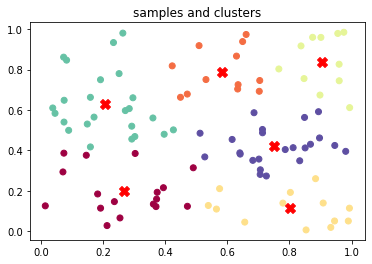

In [212]:
kmeans.kmeans()

In [213]:
test_data = np.random.rand(10, 2)
pred = kmeans.pred(test_data)

In [214]:
label = np.random.randint(0, 6, 50)

In [215]:
kmeans.EXTERNAL_INDEX(pred, pred, "JC")

1.0

In [216]:
# 选出所有可能的两两组合的数据进行计算
A = np.array([[1, 2], [2, 3], [3,4]])

In [217]:
def choose(data):
    for i in range(data.shape[0] - 1):
        temp = data[i]
        for x in range(i+1, data.shape[0]):
            print(temp, data[x])

In [218]:
choose(A)

[1 2] [2 3]
[1 2] [3 4]
[2 3] [3 4]
